## EDA for videos

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import cv2 as cv

import acquire as ac
import video as v

from typing import Tuple, Union
from numpy.typing import NDArray
from dataclasses import dataclass
from collections import deque

from importlib import reload

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

### Part I. Videos with epilepcy warnings.

Pokemon video: flashes 
- on the second 10 
- from 13 till 19 seconds
- in the end of the video: around 25-26 second

In [4]:
video1 = v.get_exploration_df('videos/Banned Pokemon Seizure Scene.mp4')

In [5]:
video1.head(2)

hue  lightness  saturation  masked_values  seconds
frame y x                                                    
0     0 0    0         36           0              0        0
        1    0         34           0              0        0

In [39]:
video1.shape

(7850000, 5)

In [42]:
fps = video1.attrs['fps']

#### 1. Lightness per second vs Lightness per frame
How differ lightness per second from lightness per frame?

In [7]:
import exploration as ex

In [16]:
reload(ex)

<module 'exploration' from '/Users/nadina/Documents/codeup/epilator/exploration.py'>

/Users/nadina/Documents/codeup/epilator/exploration.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks() // fps)


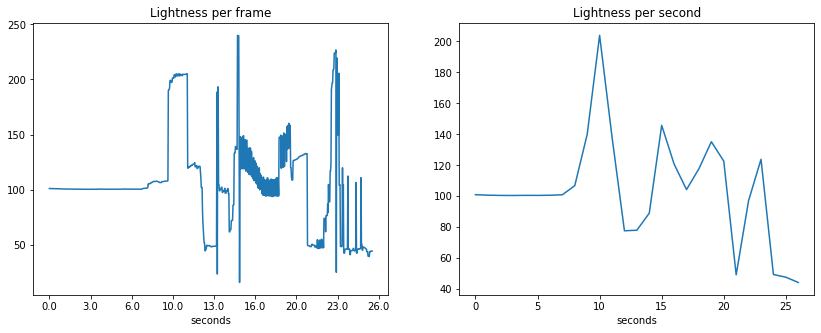

In [12]:
ex.frame_vs_sec(video1)

__Takeaway:__
- Seconds show lightness changes but don't show all changes like frames do

#### 2. How the parameters change from frame to frame?

In [13]:
cdf1 = v.get_aggregated_df(video1)

In [14]:
cdf1.describe()[1:]

,lightness,hue,saturation,masked_values,light_diff,hue_diff,saturation_diff,mask_diff
mean,105.54,90.60,111.15,759.15,0.07,-0.03,0.04,0.67
std,41.89,31.01,38.33,842.01,20.83,16.70,11.96,394.25
min,16.08,18.14,20.50,57.00,-194.00,-155.83,-114.46,"-3,528.00"
25%,96.67,83.27,91.86,97.00,-0.07,-0.16,-0.16,-1.00
50%,100.74,92.61,92.89,591.00,0.00,0.01,0.00,0.00
75%,120.16,101.00,134.68,978.00,0.04,0.18,0.26,1.00
max,240.00,173.97,236.42,"3,588.00",201.53,134.43,101.00,"3,531.00"


In [15]:
cdf1.head(1)

,lightness,hue,saturation,masked_values,light_diff,hue_diff,saturation_diff,mask_diff
frame,,,,,,,,
0,101.20,93.69,91.26,592.00,NaN,NaN,NaN,NaN


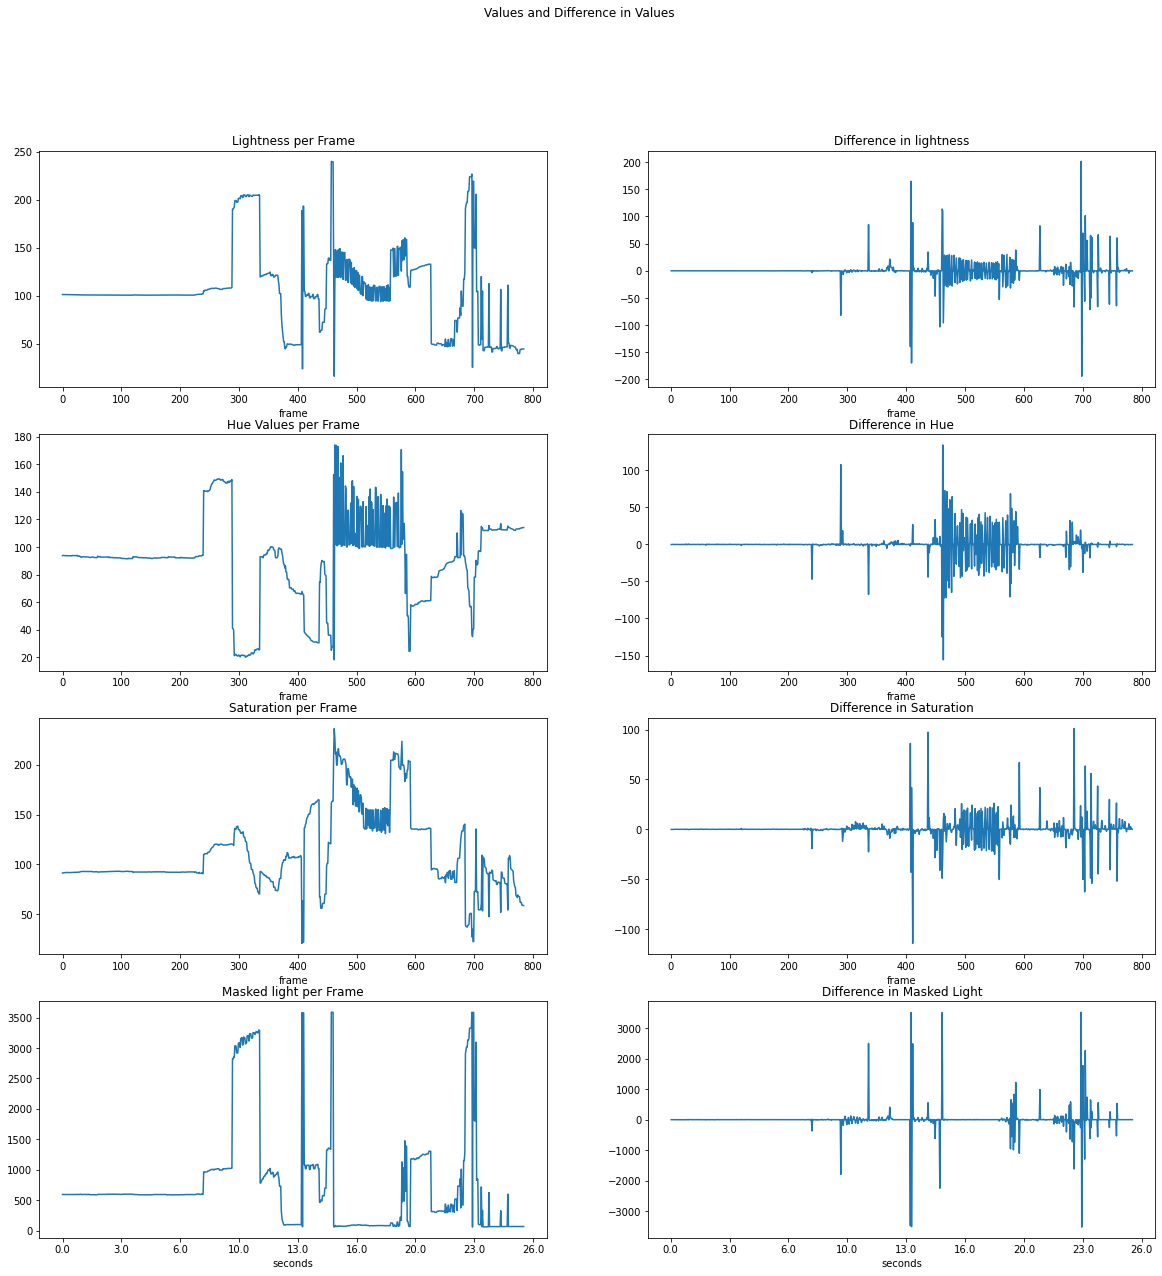

In [17]:
ex.frame_diff_changes(video1)

The best values to capture the change between frames are:
- difference in lightness
- difference in hue

#### 3. Will the product of lightness, hue and saturation give us a better picture of changes?

In [19]:
cdf1['hs_product'] = cdf1.hue * cdf1.saturation
cdf1['product'] = cdf1.lightness * cdf1.hs_product

<AxesSubplot: xlabel='frame'>

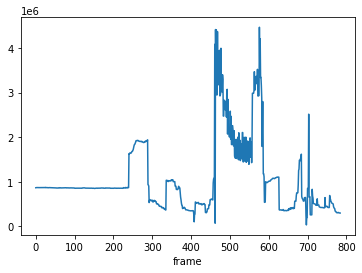

In [21]:
cdf1['product'].plot()

Text(0.5, 0, 'seconds')

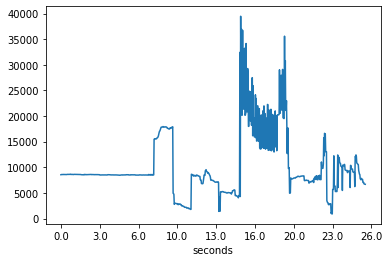

In [25]:
ax = cdf1.hs_product.plot()
ax.set_xticklabels(ax.get_xticks() // 30)
ax.set_xlabel('seconds')

Takeaway:

the product doesn't give a clear picture

#### How the hue, lightness and saturation are changing in flashing videos that we created?

In [27]:
generated_videos = [
    'videos/Black White Flash.mp4',
    'videos/Blue Green Fade.mp4',
    'videos/Blue Green Flash.mp4',
    'videos/Color Fade.mp4',
    'videos/Color Flash.mp4',
    'videos/Red Spin.mp4'
]

videos/Black White Flash.mp4


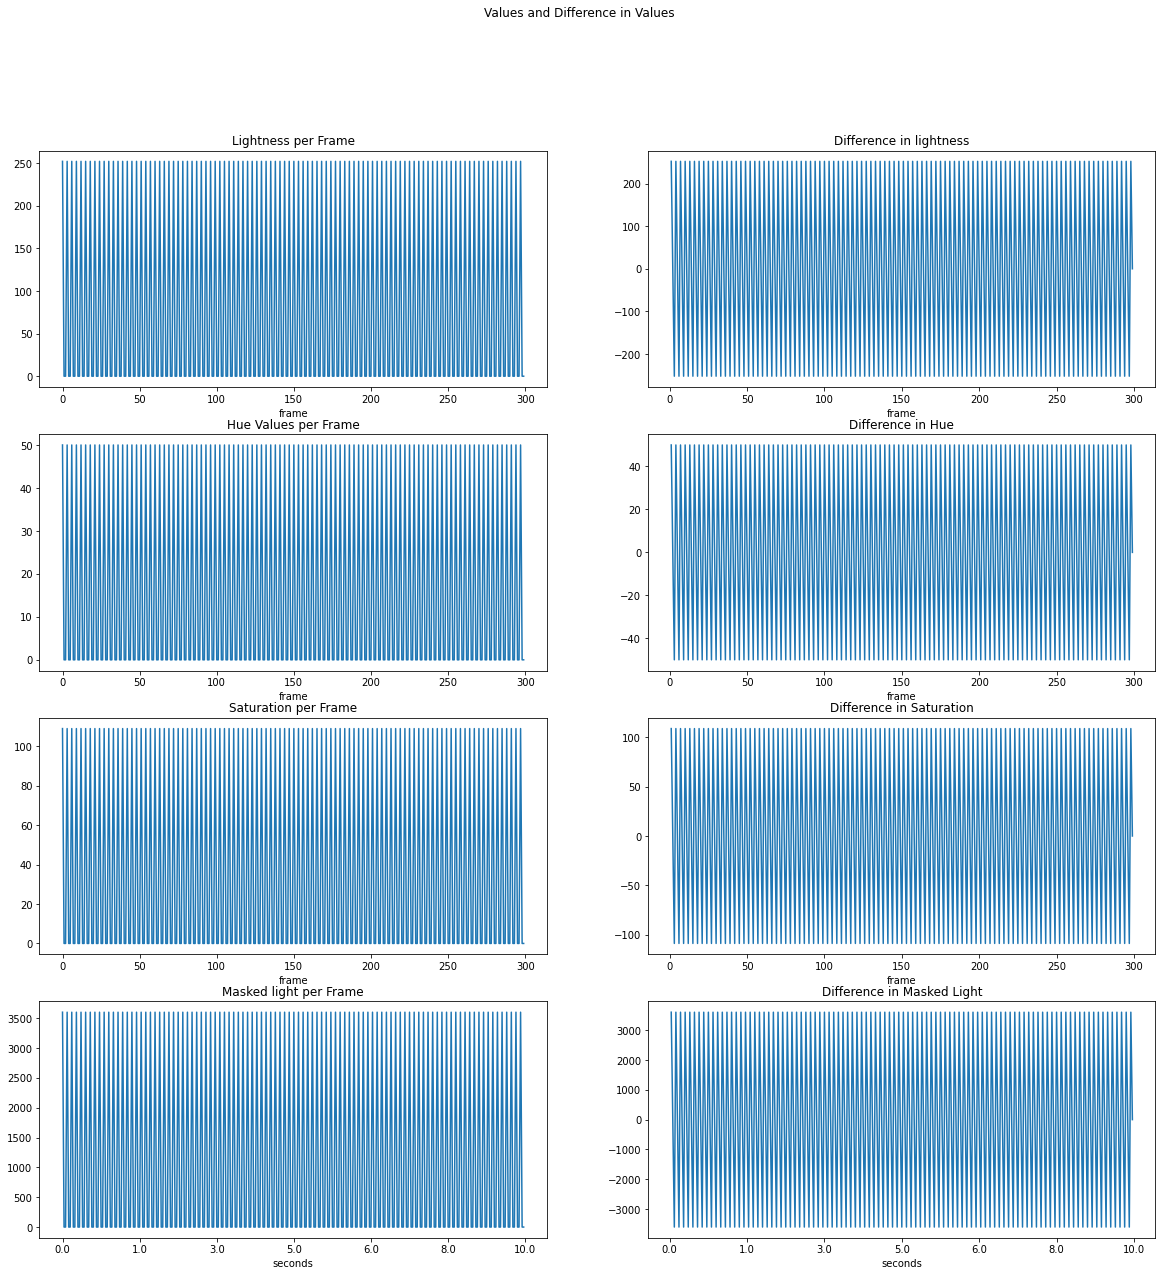

videos/Blue Green Fade.mp4


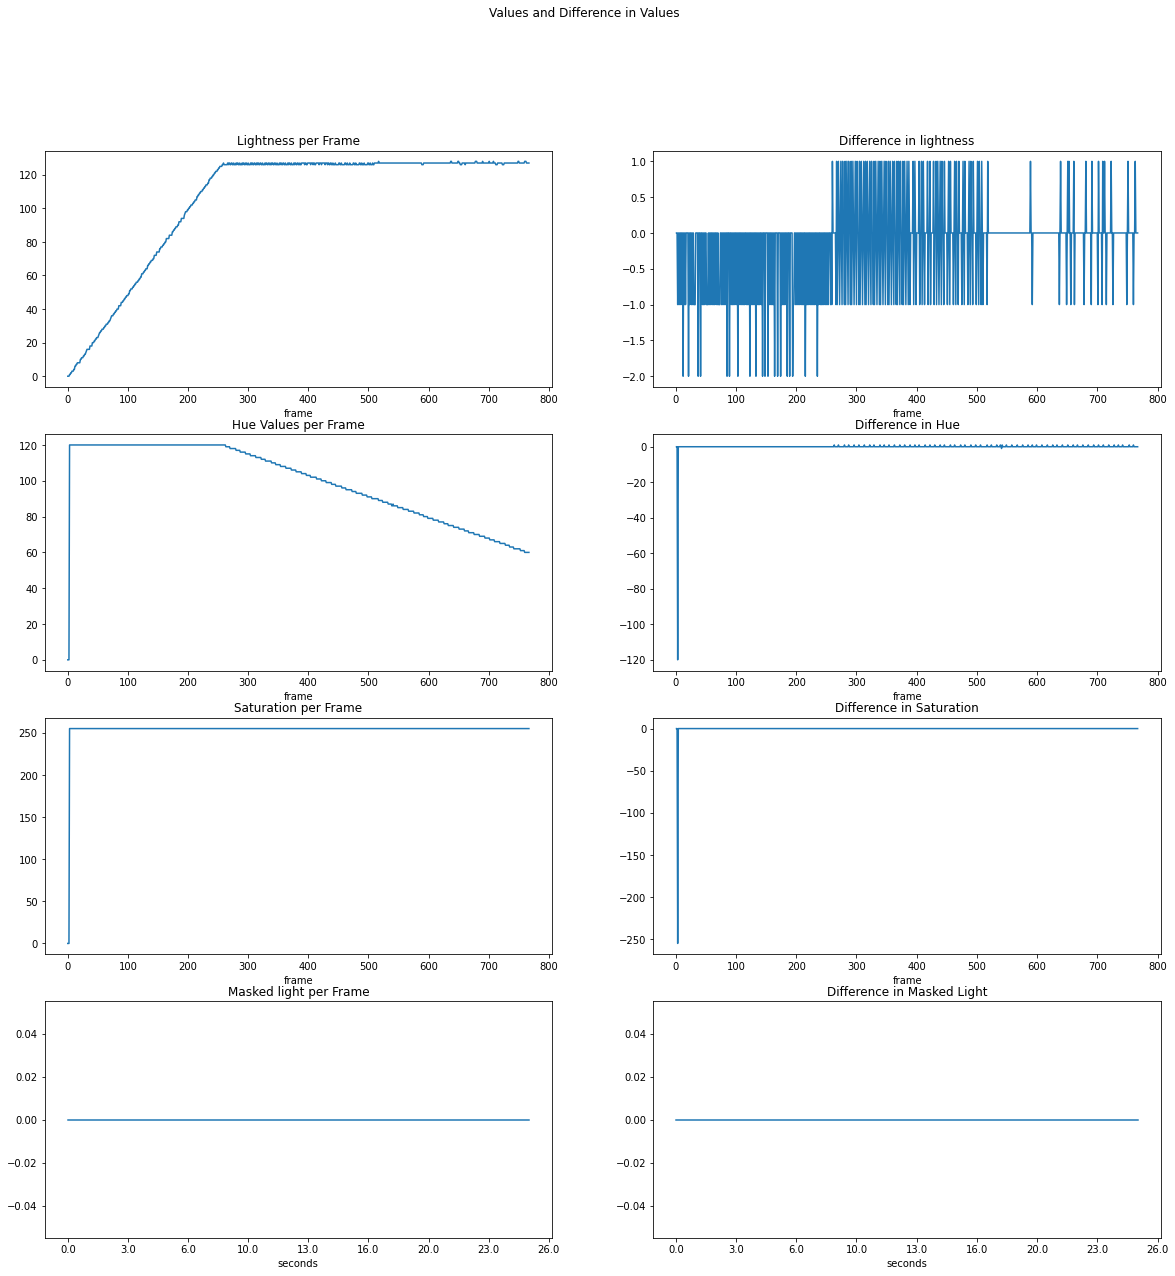

videos/Blue Green Flash.mp4


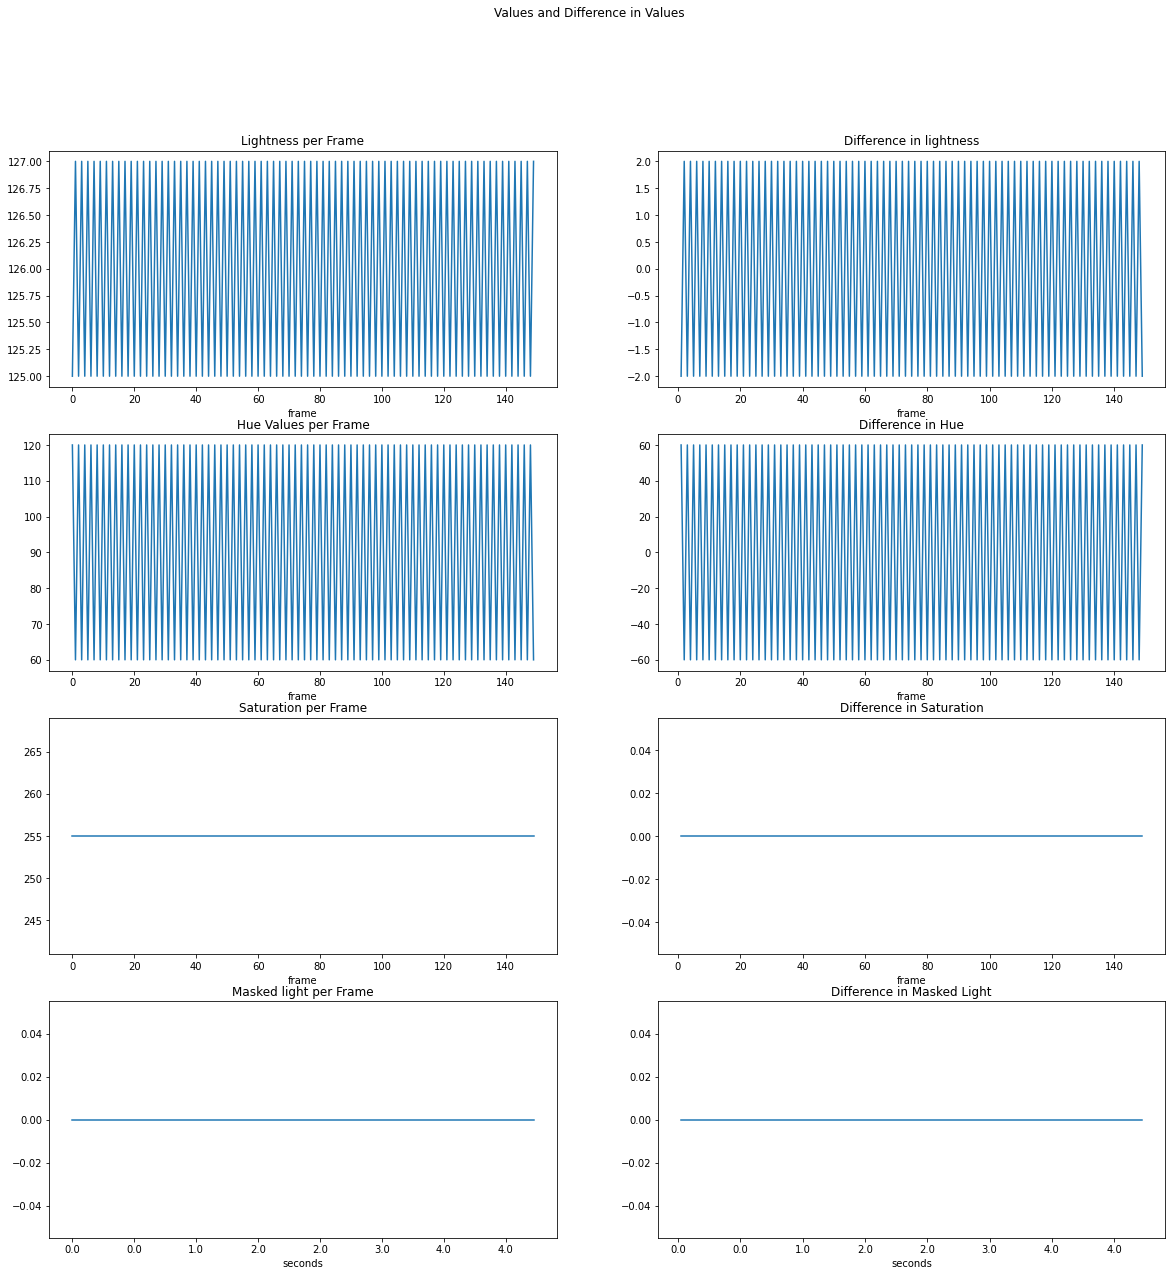

videos/Color Fade.mp4


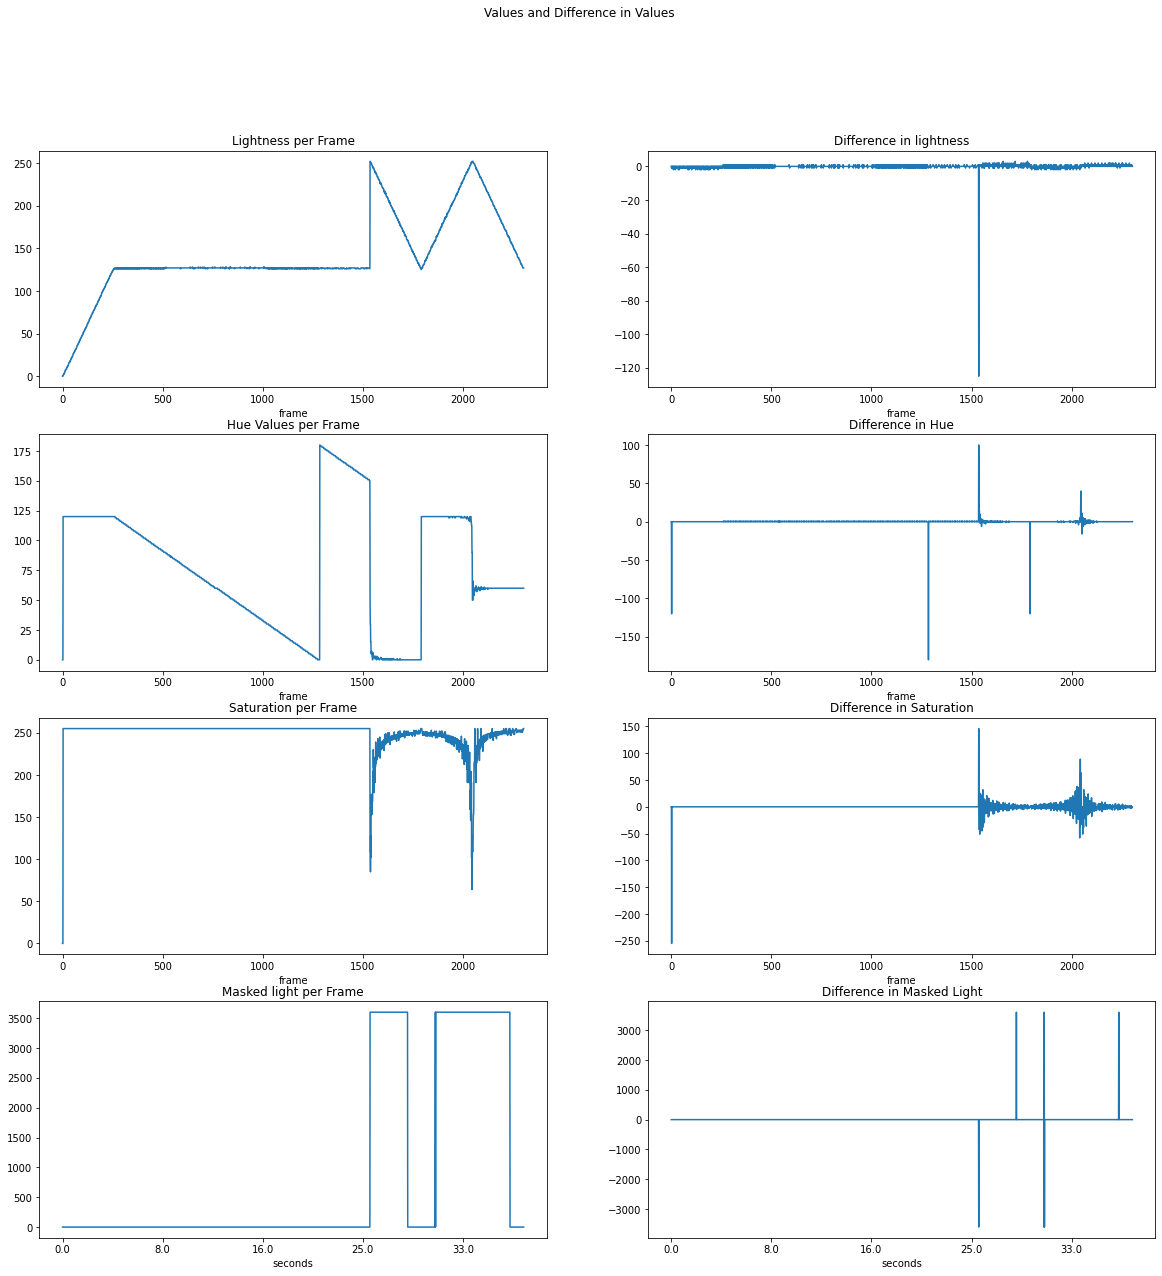

videos/Color Flash.mp4


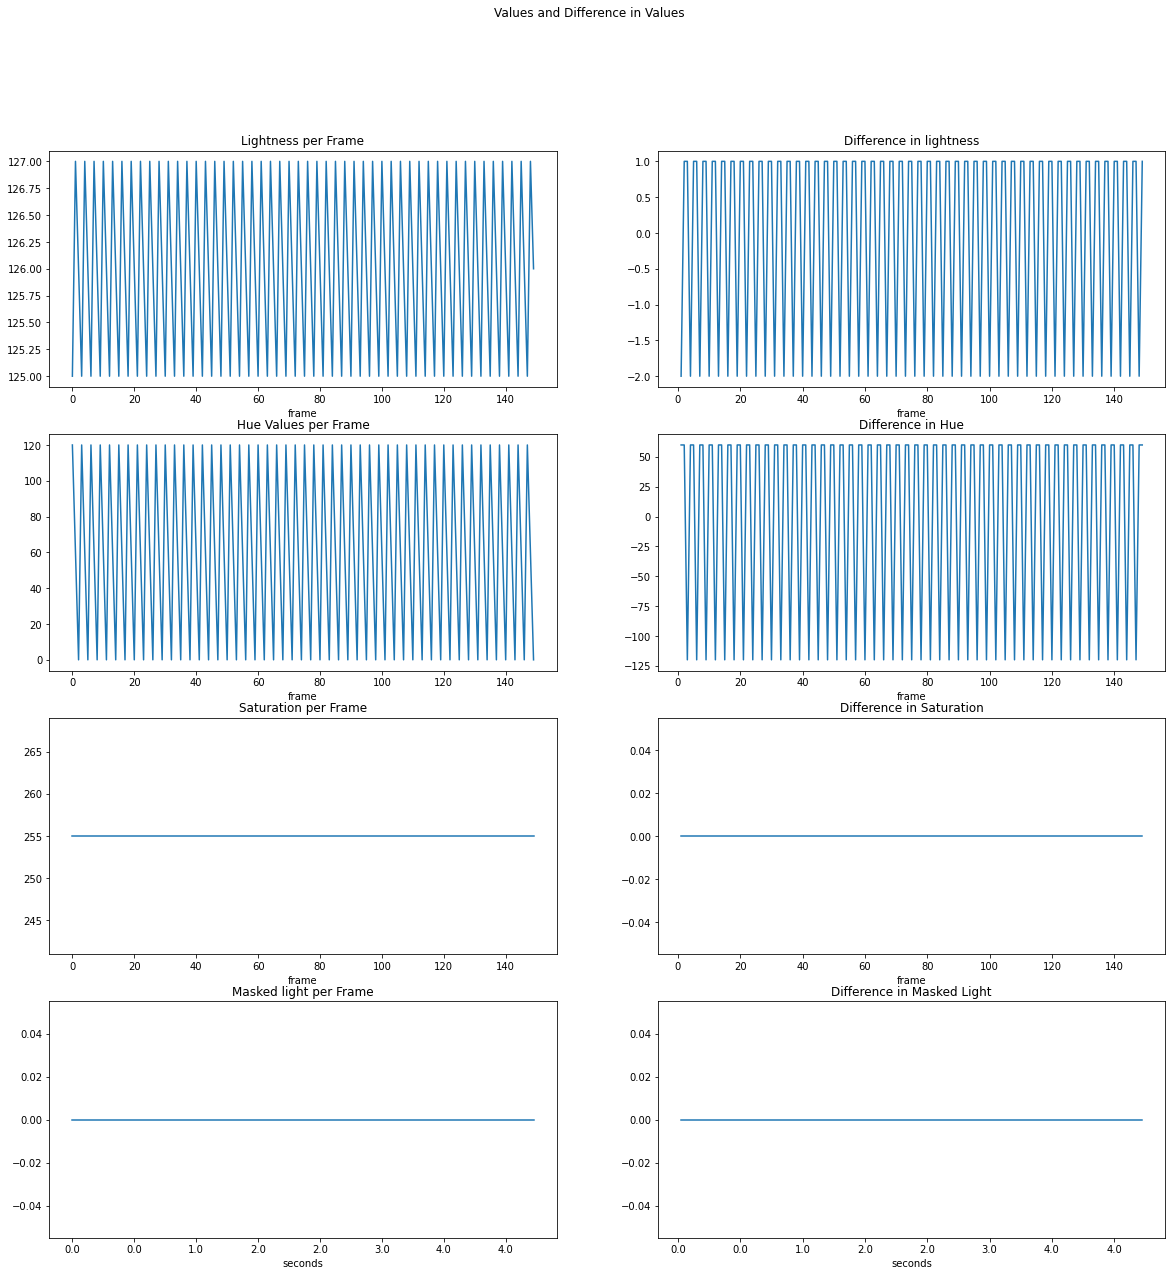

videos/Red Spin.mp4


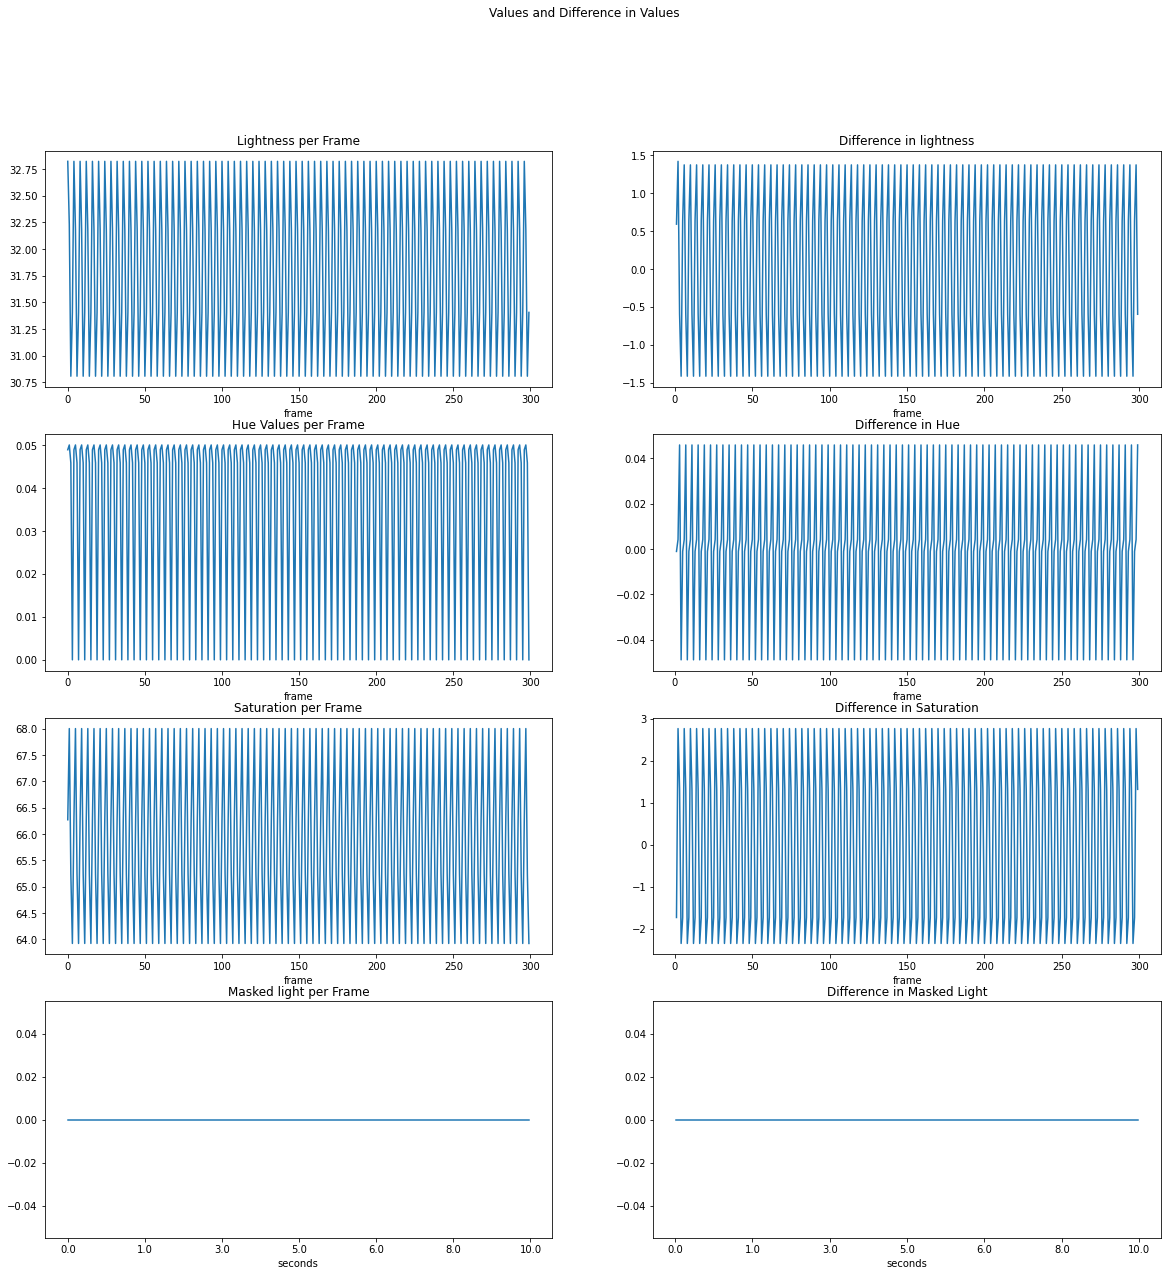

In [28]:
for video in generated_videos:
    print(video)
    df = v.get_exploration_df(video)
    ex.frame_diff_changes(df)
    